<a href="https://colab.research.google.com/github/KevinGomez26/Posterior_aprox/blob/main/Word2Vec(variational).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Advanced topics on machine learning (Final Proyect)**

by: Kevin Alejandro Hernández Gómez

**Packages and download *stopwords***

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Read file (.txt) and remove *stopwords***

In [ ]:
def get_file_data(stop_word_removal='no'):
    file_contents = []
    with open('jef_archer.txt') as f:
        file_contents = f.read()
    text = []
    for val in file_contents.split('.'):
        sent = re.findall("[A-Za-z]+", val)
        line = ''
        for words in sent:
            
            if stop_word_removal == 'yes': 
                if len(words) > 1 and words not in stop_words:
                    line = line + ' ' + words
            else:
                if len(words) > 1 :
                    line = line + ' ' + words
        text.append(line)
    return text

**Create a dictionary from text**

$V = \{ w_{i} : i \}$

In [ ]:
def generate_dictinoary_data(text):
    word_to_index= dict()
    index_to_word = dict()
    corpus = []
    count = 0
    vocab_size = 0
    
    for row in text:
        for word in row.split():
            word = word.lower()
            corpus.append(word)
            if word_to_index.get(word) == None:
                word_to_index.update ( {word : count})
                index_to_word.update ( {count : word })
                count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)
    
    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

**Encode words (*one-hot-encoding*)**

$w_{i} = [1, 0, 0, 0, ..., 0]$

In [ ]:
def get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index):
    
    trgt_word_vector = np.zeros(vocab_size)
    index_of_word_dictionary = word_to_index.get(target_word) 
    trgt_word_vector[index_of_word_dictionary] = 1
    ctxt_word_vector = np.zeros(vocab_size)
    
    for word in context_words:
        index_of_word_dictionary = word_to_index.get(word) 
        ctxt_word_vector[index_of_word_dictionary] = 1
        
    return trgt_word_vector,ctxt_word_vector

**Create training set**

$(X, Y) \rightarrow (w_{i}, \{w_{i-n}, ..., w_{i+n}\} ) $

In [ ]:
def generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,sample=None):

    training_data =  []
    training_sample_words =  []
    for i,word in enumerate(corpus):

        index_target_word = i
        target_word = word
        context_words = []

        if i == 0:  
            context_words = [corpus[x] for x in range(i + 1 , window_size + 1)] 

        elif i == len(corpus)-1:
            context_words = [corpus[x] for x in range(length_of_corpus - 2 ,length_of_corpus -2 - window_size  , -1 )]

        else:
            before_target_word_index = index_target_word - 1
            for x in range(before_target_word_index, before_target_word_index - window_size , -1):
                if x >=0:
                    context_words.extend([corpus[x]])

            after_target_word_index = index_target_word + 1
            for x in range(after_target_word_index, after_target_word_index + window_size):
                if x < len(corpus):
                    context_words.extend([corpus[x]])


        trgt_word_vector,ctxt_word_vector = get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index)
        training_data.append([trgt_word_vector,ctxt_word_vector])   
        
        if sample is not None:
            training_sample_words.append([target_word,context_words])   
        
    return training_data,training_sample_words

**Word2Vec architecture (*skip gram* - *variational*)**

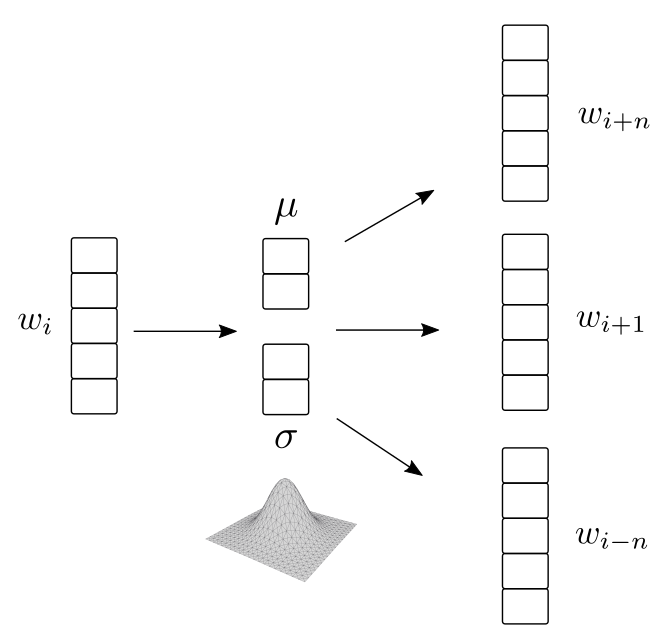

In [ ]:
def forward_prop(weight_inp_hidden,weight_hidden_output,target_word_vector):
    
    hidden_layer = np.dot(weight_inp_hidden.T, target_word_vector)
    u_mu = np.dot(weight_hidden_output.T, hidden_layer)
    u_logvar = np.dot(weight_hidden_output.T, hidden_layer)
    latent = latent_sample(u_mu, u_logvar)
    y_predicted = softmax(latent)
    
    return y_predicted, hidden_layer, latent, u_mu, u_logvar

def latent_sample(mu, logvar):

  std = np.exp(logvar * 0.5)
  return np.random.normal(loc = mu, scale=std, size=None)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

**Training error**

In [25]:
def calculate_error(y_pred,context_words):
    
    total_error = [None] * len(y_pred)
    index_of_1_in_context_words = {}
    
    for index in np.where(context_words == 1)[0]:
        index_of_1_in_context_words.update ( {index : 'yes'} )
        
    number_of_1_in_context_vector = len(index_of_1_in_context_words)
    
    for i,value in enumerate(y_pred):
        
        if index_of_1_in_context_words.get(i) != None:
            total_error[i]= (value-1) + ( (number_of_1_in_context_vector -1) * value)
        else:
            total_error[i]= (number_of_1_in_context_vector * value)
            
            
    return  np.array(total_error)

**Reconstruction loss ($R_{L}$)**

In [40]:
def calculate_loss(u,ctx):
    
    sum_1 = 0
    for index in np.where(ctx==1)[0]:
        sum_1 = sum_1 + u[index]
    
    sum_1 = -sum_1
    sum_2 = len(np.where(ctx==1)[0]) * np.log(np.sum(np.exp(u)))
    
    total_loss = sum_1 + sum_2
    return total_loss

**Total loss ($R_{L} - KL$)**

In [41]:
def vae_loss(y_pred, context_words, latent,  mu, logvar):
    variational_beta = 1
    recon_loss = calculate_loss(latent, context_words)
    kldivergence = -0.5 * np.sum(1 + logvar - mu**2 - np.exp(logvar))
    return recon_loss + variational_beta * kldivergence

**Backpropagation**

In [42]:
def backward_prop(weight_inp_hidden,weight_hidden_output,total_error, hidden_layer, target_word_vector,learning_rate):
    
    dl_weight_inp_hidden = np.outer(target_word_vector, np.dot(weight_hidden_output, total_error.T))
    dl_weight_hidden_output = np.outer(hidden_layer, total_error)

    weight_inp_hidden = weight_inp_hidden - (learning_rate * dl_weight_inp_hidden)
    weight_hidden_output = weight_hidden_output - (learning_rate * dl_weight_hidden_output)
    
    return weight_inp_hidden,weight_hidden_output

**Training**

In [43]:
def train(word_embedding_dimension,window_size,epochs,training_data,learning_rate,disp = 'no',interval=-1):
    
    weights_input_hidden = np.random.uniform(-1, 1, (vocab_size, word_embedding_dimension))
    weights_hidden_output = np.random.uniform(-1, 1, (word_embedding_dimension, vocab_size))
    
    epoch_loss = []
    weights_1 = []
    weights_2 = []
    
    for epoch in range(epochs):
        loss = 0

        for target,context in training_data:
            y_pred, hidden_layer, latent, u_mu, u_logvar = forward_prop(weights_input_hidden,weights_hidden_output,target)

            total_error = calculate_error(y_pred, context)

            weights_input_hidden,weights_hidden_output = backward_prop(
                weights_input_hidden,weights_hidden_output ,total_error, hidden_layer, target,learning_rate
            )
            loss_temp = vae_loss(y_pred, context, latent, u_mu, u_logvar)
            
            loss += loss_temp
        
        epoch_loss.append( loss )
        weights_1.append(weights_input_hidden)
        weights_2.append(weights_hidden_output)
        
        if disp == 'yes':
            if epoch ==0 or epoch % interval ==0 or epoch == epochs -1:
                print('Epoch: %s. Loss:%s' %(epoch,loss))
    return epoch_loss,np.array(weights_1),np.array(weights_2)

**Plot embedding (*TSNE*)**

In [30]:
def word_similarity_scatter_plot(index_to_word,weights_input_hidden,weights_hidden_output):
    
    latent_space = []

    for target,context in training_data:
        y_pred, hidden_layer, latent, u_mu, u_logvar = forward_prop(weights_input_hidden,weights_hidden_output,target)
        latent_space.append(u_mu)

    labels = []
    tokens = []
    
    for key,value in index_to_word.items():
        tokens.append(latent_space[key])
        labels.append(value)

    tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    z = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        z.append(value[2])

    data = {'x': x, 'y': y, 'z': z, 'label': labels}
    df = pd.DataFrame(data)
    fig = px.scatter_3d(df, x='x', y='y', z='z',hover_name = labels)
    fig.show()

    return df

**Example**

In [36]:
text = get_file_data(stop_word_removal='yes')
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)

window_size = 2
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,sample=None)

word_embedding_dimension = 5
epochs = 15
learning_rate = 0.01
epoch_loss, weights_1,weights_2 = train(word_embedding_dimension,window_size,epochs,training_data,learning_rate,disp = 'yes',interval=-1)

Epoch: 0. Loss:330888.2714281466
Epoch: 1. Loss:281990.0142350061
Epoch: 2. Loss:249288.8721680703
Epoch: 3. Loss:225072.96500384278
Epoch: 4. Loss:206891.8001018395
Epoch: 5. Loss:192790.2090222655
Epoch: 6. Loss:181911.0955649856
Epoch: 7. Loss:172870.12450897312
Epoch: 8. Loss:165779.97463377262
Epoch: 9. Loss:160411.6678809039
Epoch: 10. Loss:156376.8071045325
Epoch: 11. Loss:153065.37589350855
Epoch: 12. Loss:150835.8698571485
Epoch: 13. Loss:149524.32488219943
Epoch: 14. Loss:148486.09458103965


**Plot Loss**

Text(0, 0.5, 'Loss')

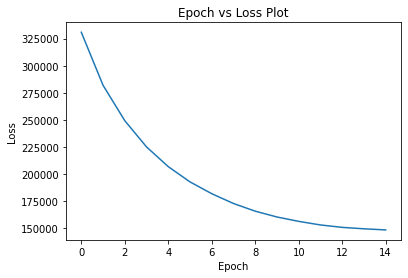

In [37]:
plt.plot(epoch_loss)
plt.title('Epoch vs Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')

**3D Word embedding**

In [38]:
data = word_similarity_scatter_plot(index_to_word,weights_1[-1],weights_2[-1])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

